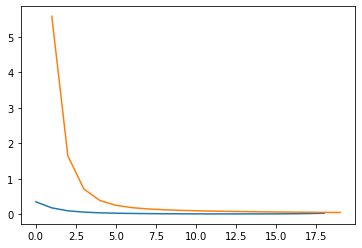

174     , -2.985e+06  , array([ 16.6108    ,  1.64411    ])
175     , -2.98739e+06, array([ 16.6275    ,  1.64411    ])
176     , -2.98518e+06, array([ 16.6108    ,  1.64575    ])
177     , -1.08329e+06, array([ 6.06586    ,  1.52881    ])
178     , -1.08456e+06, array([ 6.07193    ,  1.52881    ])
179     , -1.08334e+06, array([ 6.06586    ,  1.53034    ])
183     , -1.05484e+06, array([ 5.89391    ,  1.97659    ])
184     , -1.056e+06  , array([ 5.89981    ,  1.97659    ])
185     , -1.05484e+06, array([ 5.89391    ,  1.97857    ])
186     , -992456     , array([ 5.67048    ,  2.79153    ])
187     , -993498     , array([ 5.67615    ,  2.79153    ])
188     , -992309     , array([ 5.67048    ,  2.79432    ])
192     , -935282     , array([ 5.56252    ,  3.31448    ])
193     , -936291     , array([ 5.56809    ,  3.31448    ])
194     , -934995     , array([ 5.56252    ,  3.3178     ])
195     , -812871     , array([ 5.40746    ,  4.26678    ])
196     , -813735     , array([ 5.41287 

348     , -604572     , array([ 4.46232    ,  6.89856    ])
349     , -604585     , array([ 4.46678    ,  6.89856    ])
350     , -604573     , array([ 4.46232    ,  6.90546    ])
351     , -604572     , array([ 4.46232    ,  6.89856    ])
352     , -604585     , array([ 4.46678    ,  6.89856    ])
353     , -604573     , array([ 4.46232    ,  6.90546    ])
354     , -604572     , array([ 4.46232    ,  6.89856    ])
355     , -604585     , array([ 4.46678    ,  6.89856    ])
356     , -604573     , array([ 4.46232    ,  6.90546    ])
357     , -604572     , array([ 4.46232    ,  6.89856    ])
358     , -604585     , array([ 4.46678    ,  6.89856    ])
359     , -604573     , array([ 4.46232    ,  6.90546    ])
360     , -604572     , array([ 4.46232    ,  6.89856    ])
361     , -604585     , array([ 4.46678    ,  6.89856    ])
362     , -604573     , array([ 4.46232    ,  6.90546    ])
363     , -604572     , array([ 4.46232    ,  6.89856    ])
364     , -604585     , array([ 4.46678 

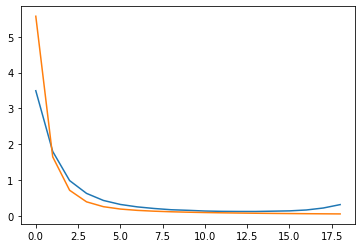

0.003955527574237769 4.462318085451495 6.898558577233687 32962.72978531474 7386.907242848329 4.462318085451495 6.898558577233687


In [3]:
#input sfs, corrected raisd file, file prefix  

#fit demographic model
#print obs and exp sfs to figure
#print prefix, parameters, etc. to data file for alter concactenation
#filter raisd file for outliers



import dadi
from dadi import Numerics, PhiManip, Integration, Spectrum
import numpy as np
import os
import matplotlib.pyplot as plt
import dadi.DFE as DFE


def two_epoch(params, ns, pts):
    """
    Instantaneous size change some time ago.

    params = (nu,T)
    ns = (n1,)

    nu: Ratio of contemporary to ancient population size
    T: Time in the past at which size change happened (in units of 2*Na 
       generations) 
    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu,T = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)
    
    phi = Integration.one_pop(phi, xx, T, nu)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs


def three_epoch(params, ns, pts):
    """
    params = (nuB,nuF,TB,TF)
    ns = (n1,)

    nuB: Ratio of bottleneck population size to ancient pop size
    nuF: Ratio of contemporary to ancient pop size
    TB: Length of bottleneck (in units of 2*Na generations) 
    TF: Time since bottleneck recovery (in units of 2*Na generations) 

    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nuB,nuF,TB,TF = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, TB, nuB)
    phi = Integration.one_pop(phi, xx, TF, nuF)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

#with open("../data/angsd_pi/v5--Teo--random1_Palmar_Chico.sfs") as f:
#with open("../data/angsd_sfs/v5--Teo--Amatlan_de_Canas_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:
#with open("../data/angsd_sfs/v5--Teo--random1_Palmar_Chico_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:    
    sfs = f.readlines()[0].split()
    sfs = [float(s) for s in sfs]


fs = dadi.Spectrum(np.round(sfs, 0))
#sel_fs = dadi.Spectrum(np.round(sel_sfs, 0))

params = (10, 1)
ns = fs.sample_sizes
pts = [100]

my_extrap_func = Numerics.make_extrap_log_func(two_epoch)
model = my_extrap_func(params, ns, pts)

plt.plot(sfs[1:-1]/np.sum(sfs[1:-1]))
plt.plot(my_extrap_func(params, ns, pts))
plt.show()

ll_model = dadi.Inference.ll_multinom(model, fs)
theta = dadi.Inference.optimal_sfs_scaling(model, fs)

lower_bound, upper_bound = [1e-2, 1e-2], [1e2, 1e2]
p0 = dadi.Misc.perturb_params(params, lower_bound=lower_bound, upper_bound=upper_bound)
dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=1000, lower_bound=lower_bound, upper_bound=upper_bound)

#p0 = dadi.Misc.perturb_params(params)
#dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=1000)


plt.plot(sfs[1:-1]/theta)
plt.plot(my_extrap_func(params, ns, pts)[1:-1])
plt.show()

ns = ns
reps = 10
bps = 10000

mu = 3e-8
nu, T = dadi_opt

theta_sc = theta / sum(sfs)
N_ref = theta_sc/(4*mu)
N_anc = N_ref/ nu
c = 1.6e-8
rho = 4*N_ref*c

print(f"{theta_sc} {nu} {T} {N_ref} {N_anc} {nu} {T}")

20932.047368421056 82871.0
0.01146289428577903


array([20])

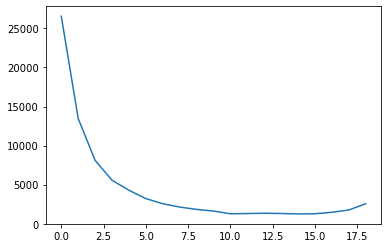

In [17]:
plt.plot(sfs[1:-1])

print(fs.pi(), sum(fs[1:-1]))
print(fs.pi()/sum(sfs))

fs.sample_sizes

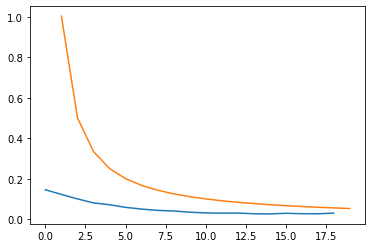

13004   , -6910.12    , array([ 1.16899    ,  1.92064    ,  1.16745    ,  0.609928   ])
13005   , -6906.86    , array([ 1.17016    ,  1.92064    ,  1.16745    ,  0.609928   ])
13006   , -6917.89    , array([ 1.16899    ,  1.92256    ,  1.16745    ,  0.609928   ])
13007   , -6909.56    , array([ 1.16899    ,  1.92064    ,  1.16861    ,  0.609928   ])
13008   , -6909.95    , array([ 1.16899    ,  1.92064    ,  1.16745    ,  0.610538   ])
13009   , -1537.78    , array([ 1.72706    ,  0.758659   ,  1.24904    ,  0.62279    ])
13010   , -1536.86    , array([ 1.72879    ,  0.758659   ,  1.24904    ,  0.62279    ])
13011   , -1539.72    , array([ 1.72706    ,  0.759418   ,  1.24904    ,  0.62279    ])
13012   , -1537.3     , array([ 1.72706    ,  0.758659   ,  1.25029    ,  0.62279    ])
13013   , -1538.2     , array([ 1.72706    ,  0.758659   ,  1.24904    ,  0.623413   ])
13014   , -3332.19    , array([ 19.3552    ,  0.711289   ,  3339.34    ,  8.58919e-06])
13015   , -3332.19    , array([ 

13098   , -302.727    , array([ 105.202    ,  4.02681    ,  3980.37    ,  0.697716   ])
13099   , -302.627    , array([ 115.556    ,  4.17663    ,  4584.22    ,  0.717205   ])
13100   , -302.625    , array([ 115.672    ,  4.17663    ,  4584.22    ,  0.717205   ])
13101   , -302.635    , array([ 115.556    ,  4.18081    ,  4584.22    ,  0.717205   ])
13102   , -302.627    , array([ 115.556    ,  4.17663    ,  4588.81    ,  0.717205   ])
13103   , -302.623    , array([ 115.556    ,  4.17663    ,  4584.22    ,  0.717922   ])
13104   , -302.648    , array([ 112.174    ,  4.12319    ,  4380.08    ,  0.709884   ])
13105   , -302.647    , array([ 112.287    ,  4.12319    ,  4380.08    ,  0.709884   ])
13106   , -302.652    , array([ 112.174    ,  4.12732    ,  4380.08    ,  0.709884   ])
13107   , -302.648    , array([ 112.174    ,  4.12319    ,  4384.46    ,  0.709884   ])
13108   , -302.649    , array([ 112.174    ,  4.12319    ,  4380.08    ,  0.710594   ])
13109   , -302.628    , array([ 

13193   , -302.623    , array([ 115.556    ,  4.17663    ,  4584.22    ,  0.717922   ])
13194   , -302.627    , array([ 115.556    ,  4.17663    ,  4584.22    ,  0.717205   ])
13195   , -302.625    , array([ 115.672    ,  4.17663    ,  4584.22    ,  0.717205   ])
13196   , -302.635    , array([ 115.556    ,  4.18081    ,  4584.22    ,  0.717205   ])
13197   , -302.627    , array([ 115.556    ,  4.17663    ,  4588.81    ,  0.717205   ])
13198   , -302.623    , array([ 115.556    ,  4.17663    ,  4584.22    ,  0.717922   ])
13199   , -302.627    , array([ 115.556    ,  4.17663    ,  4584.22    ,  0.717205   ])
13200   , -302.625    , array([ 115.672    ,  4.17663    ,  4584.22    ,  0.717205   ])
13201   , -302.635    , array([ 115.556    ,  4.18081    ,  4584.22    ,  0.717205   ])
13202   , -302.627    , array([ 115.556    ,  4.17663    ,  4588.81    ,  0.717205   ])
13203   , -302.623    , array([ 115.556    ,  4.17663    ,  4584.22    ,  0.717922   ])
13204   , -302.627    , array([ 

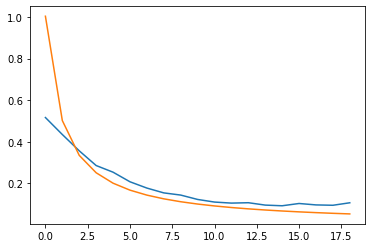

14411.790279626191 1665371.0589226012 60192.71974053776


In [83]:
#input sfs, corrected raisd file, file prefix  

#fit demographic model
#print obs and exp sfs to figure
#print prefix, parameters, etc. to data file for alter concactenation
#filter raisd file for outliers



import dadi
from dadi import Numerics, PhiManip, Integration, Spectrum
import numpy as np
import os
import matplotlib.pyplot as plt
import dadi.DFE as DFE


def two_epoch(params, ns, pts):
    """
    Instantaneous size change some time ago.

    params = (nu,T)
    ns = (n1,)

    nu: Ratio of contemporary to ancient population size
    T: Time in the past at which size change happened (in units of 2*Na 
       generations) 
    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu,T = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)
    
    phi = Integration.one_pop(phi, xx, T, nu)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs


def three_epoch(params, ns, pts):
    """
    params = (nuB,nuF,TB,TF)
    ns = (n1,)

    nuB: Ratio of bottleneck population size to ancient pop size
    nuF: Ratio of contemporary to ancient pop size
    TB: Length of bottleneck (in units of 2*Na generations) 
    TF: Time since bottleneck recovery (in units of 2*Na generations) 

    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nuB,nuF,TB,TF = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, TB, nuB)
    phi = Integration.one_pop(phi, xx, TF, nuF)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs


with open("../data/angsd_sfs/v5--LR--Crucero_Lagunitas_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:
#with open("../data/angsd_sfs/v5--LR--random1_Palmar_Chico_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:   
    sfs = f.readlines()[0].split()
    sfs = [float(s) for s in sfs]

with open("../data/angsd_sfs/v5--Teo--Crucero_Lagunitas_fold0_AT,TA,GC,CG_sfs.txt") as f:
    sel_sfs = f.readlines()[0].split()
    sel_sfs = [float(s) for s in sfs]


fs = dadi.Spectrum(np.round(sfs, 0))

sel_fs = dadi.Spectrum(np.round(sel_sfs, 0))

params = (1, 1, 1, 1)
ns = fs.sample_sizes
pts = [100]

my_extrap_func = Numerics.make_extrap_log_func(three_epoch)
model = my_extrap_func(params, ns, pts)

plt.plot(sfs[1:-1]/np.sum(sfs[1:-1]))
plt.plot(my_extrap_func(params, ns, pts))
plt.show()

ll_model = dadi.Inference.ll_multinom(model, fs)
theta = dadi.Inference.optimal_sfs_scaling(model, fs)


#lower_bound, upper_bound = [1e-4, 1e-4, 1e-4, 1e-4], [2e1, 2e1, 2, 2]
#p0 = dadi.Misc.perturb_params(params, lower_bound=lower_bound, upper_bound=upper_bound)
#dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=100, lower_bound=lower_bound, upper_bound=upper_bound)

p0 = dadi.Misc.perturb_params(params)
dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=100)

plt.plot(sfs[1:-1]/theta)
plt.plot(my_extrap_func(params, ns, pts)[1:-1])
plt.show()

ns = ns
reps = 10
bps = 10000

mu = 3e-8
nu_B, nu_A, T_B, T_R = dadi_opt
theta_sc = theta / sum(sfs)
N_0 = theta_sc/(4*mu)
N_A = N_0 / nu_A
N_B = nu_B * N_A

c = 1.6e-8
rho = 4*N_ref*c

print(f"{N_A} {N_B} {N_0}")

In [11]:


spectra = DFE.Cache1D(dadi_opt, ns, DFE.DemogSelModels.two_epoch, pts_l=pts, 
                      gamma_bounds=(1e-5, 500), gamma_pts=100, verbose=True,
                      mp=True)

sel_params = [0.2, 1000.]
lower_bound, upper_bound = [1e-3, 1e-2], [1, 50000.]


p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                              upper_bound=upper_bound)


popt = dadi.Inference.optimize_log(p0, sel_fs, spectra.integrate, pts=None,
                                   func_args=[DFE.PDFs.gamma, theta],
                                   lower_bound=lower_bound, upper_bound=upper_bound, 
                                   verbose=len(sel_params), maxiter=10, multinom=False)


popt


my_extrap_func = Numerics.make_extrap_log_func(DFE.DemogSelModels.two_epoch)
#model = my_extrap_func(popt, ns, pts)

popt

array([0.88044928, 0.01029516])

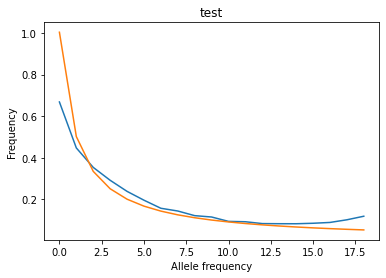

In [14]:
plt.plot(sfs[1:-1]/theta)
plt.plot(my_extrap_func(params, ns, pts)[1:-1])
plt.xlabel("Allele frequency") 
plt.ylabel("Frequency")
plt.title(f"{}")
plt.savefig(f'../figures/{}')


In [219]:
theta_sc

0.005646033111461046